In [1]:
# -------------- IMPORTS -------------- #
import os
import numpy as np
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from tqdm import tqdm
from scipy.spatial.distance import cdist

Using TensorFlow backend.
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: Future

In [2]:
# -------------- FUNCTIONS -------------- #
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x).reshape(-1)
    return features

def extract_features_from_directory(dir_path, model):
    features_list = dict()
    files = os.listdir(dir_path)
    for file in tqdm(files):
        features_list[file.replace('.jpg','')] = extract_features((dir_path + file), model)
    return features_list

### Generate dataset1 and dataset2
def generate_datasets(selected_images_keys_list, features_list):
    dataset = []
    names   = []
    selected_dataset = []
    selected_names   = []
    for key, value in features_list.items():
        sw=0
        for k in selected_images_keys_list:
            if key == k:
                selected_dataset.append(features_list[key])
                selected_names.append(key)
                sw=1
        if sw==0:
            dataset.append(value)
            names.append(key)
    return np.asarray(selected_names), np.asarray(selected_dataset), np.asarray(names), np.asarray(dataset)

In [5]:
# -------------- DEFINE BASIC THINGS -------------- #
# Load the model to be used as feature extractor
model = ResNet50(weights='imagenet', include_top=False)

# Extract features
features_list = extract_features_from_directory(dir_path='/Users/bekyilma/Documents/Visual_art-recommender/ng_images/', model=model)

100%|██████████| 2325/2325 [04:30<00:00,  8.61it/s]


### Import here and run experiments 
> Import user preferences and weights as (selected_images_keys_list, weights)

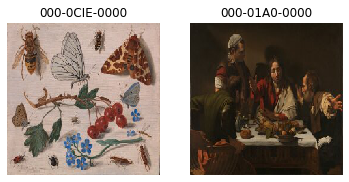

In [7]:
# -------------- SELECT IMAGES TO COMPARE -------------- #
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def print_images(dir_path, selected_images_keys_list):
    fig = plt.figure()
    for i in range(len(selected_images_keys_list)):
        img_path = dir_path + selected_images_keys_list[i] + '.jpg'
        img = image.load_img(img_path, target_size=(224, 224))
        a = fig.add_subplot(1, len(selected_images_keys_list), i+1, autoscale_on=True)
        imgplot = plt.imshow(img)
        a.set_title(selected_images_keys_list[i])
        plt.axis('off')

dir_path='/Users/bekyilma/Documents/Visual_art-recommender/ng_images/'
selected_images_keys_list = ['000-0CIE-0000', '000-01A0-0000']
weights = np.asarray([0.1, 0.9]) # Give one weight/rating per painting
print_images(dir_path, selected_images_keys_list)

> Dataset similarity per selected image

Nearest to image 000-0CIE-0000
Nearest to image 000-01A0-0000


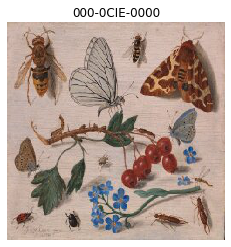

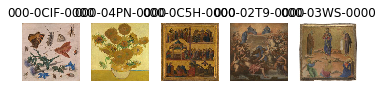

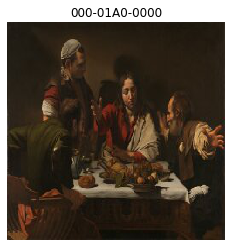

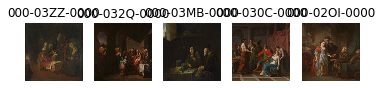

In [8]:
# -------------- MEASURE SIMILARITY -------------- #
topn = 5
selected_names, selected_dataset, names, dataset = generate_datasets(selected_images_keys_list, features_list)
distances = cdist(selected_dataset, dataset, 'cosine')

for i in range(distances.shape[0]):
    nearest_ids = np.argsort(distances[i,:]).reshape(-1)[:topn]
    nearest_names = names[nearest_ids]
    print('Nearest to image', selected_names[i])
    print_images(dir_path, [selected_names[i]])
    print_images(dir_path, nearest_names)

In [164]:
# -------------- WEIGHTING MECHANISM -------------- #
weights = weights.reshape(-1,1)
N = distances.shape[0]
weighted_averaged_distances = np.sum(np.multiply(weights,distances), axis=0) / N
print(weighted_averaged_distances)

[0.45328847 0.40999528 0.45746974 0.44368717 0.45498084 0.40900105
 0.44047915 0.44134874 0.45753782 0.45306338 0.36113195 0.43904686
 0.42896688 0.43749519 0.43694611 0.31175828]


Selected paintings:


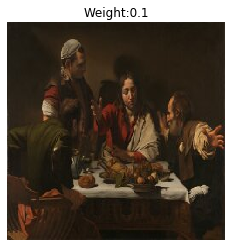

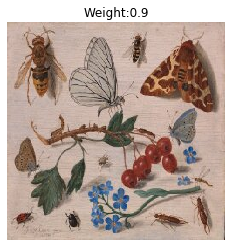

In [165]:
print('Selected paintings:')
for i in range(len(selected_names)):
    fig = plt.figure()
    img_path = dir_path + selected_names[i] + '.jpg'
    img = image.load_img(img_path, target_size=(224, 224))
    imgplot = plt.imshow(img) 
    plt.title('Weight:' + str(weights[i,0]))
    plt.axis('off')

Recommended paintings:


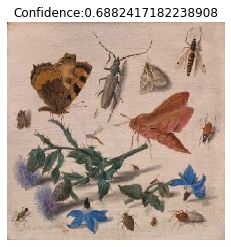

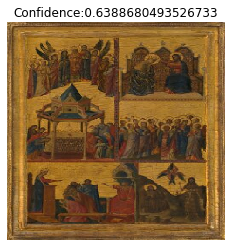

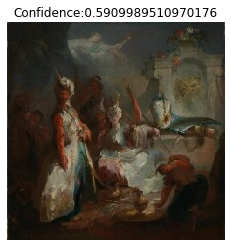

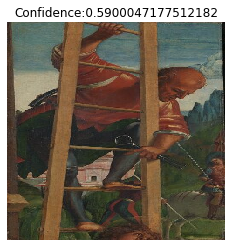

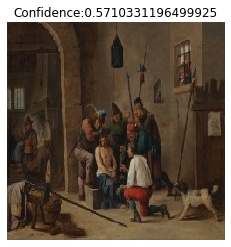

In [169]:
# -------------- PRINT RESULTS -------------- #
nearest_ids = np.argsort(weighted_averaged_distances)[:topn]
nearest_names = names[nearest_ids]
print('Recommended paintings:')
for i in range(len(nearest_names)):
    fig = plt.figure()
    img_path = dir_path + nearest_names[i] + '.jpg'
    img = image.load_img(img_path, target_size=(224, 224))
    imgplot = plt.imshow(img) 
    plt.title('Confidence:' + str(1-weighted_averaged_distances[nearest_ids[i]]))
    plt.axis('off')

# for the confidence we just do: 1 - weighted_averaged_distances value, 
# so that the lower the distance between paintings, the highger the confidence